# Hybrid & Consensus Table

This part, produces two score per point: K-Means distance and DBSCAN noise label. 

The table will have 
- Union: anomaly if K-Means or DBSCAN flags (higher recall)
- Intersection: anomaly if both flag (higher precision)

In [2]:
import os
import sys
from pathlib import Path

# use Path(os.getcwd()) outside the vscode to get the root folder

# Root Folder - use hardcode in vscode jupyter notebook, due to kernel inconsistency
ROOT_DIR = "d:/Desktop/Data Science Learning/DS Self Projects/IITG Capstone/Stock Market Anomaly Detection/stock-anomaly-detector/"
project_root = ROOT_DIR

# selecing the root as working directory
os.chdir(project_root)


# Adding the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root) 


import pandas as pd
import numpy as np

#### Load K-means & DBSCAN Anomaly Data  

In [7]:
# loading K-means anomalies
df_kmeans_test = pd.read_csv("data/processed/anomalies_kmeans_test.csv", parse_dates=["date"])

df_kmeans_test.head()

,date,ticker,anomaly_flag,cluster,distance
0,2020-02-24,QQQ,1,0,3.193727
1,2020-02-27,QQQ,1,0,3.030025
2,2020-03-02,QQQ,1,1,2.995849
3,2020-03-13,QQQ,1,1,2.503699
4,2020-03-16,QQQ,1,0,2.736320


In [9]:
# loading DBSCAN anomalies

df_dbscan_test = pd.read_csv("data/processed/anomalies_dbscan_test.csv", parse_dates=["date"])

df_dbscan_test.head()

,date,ticker,ret,anomaly_flag,cluster
0,2020-03-27,QQQ,-0.034393,1,-1
1,2020-03-30,QQQ,0.036373,1,-1
2,2020-01-31,AMZN,0.073791,1,-1
3,2020-03-13,MSFT,0.142169,1,-1
4,2020-03-16,NVDA,-0.184521,1,-1


In [10]:
# building consensus table 

df_consensus = (
    df_kmeans_test[["date", "ticker", "anomaly_flag"]].rename(columns={"anomaly_flag": "kmeans_flag"}).merge(
        df_dbscan_test[["date", "ticker", "anomaly_flag"]].rename(columns={"anomaly_flag" : "dbscan_flag"}), on=["date", "ticker"], how="outer").fillna(0)
)

df_consensus.head()

,date,ticker,kmeans_flag,dbscan_flag
0,2020-01-06,GOOGL,1,0.0
1,2020-01-08,TSLA,1,0.0
2,2020-01-14,NVDA,1,0.0
3,2020-01-29,FB,1,1.0
4,2020-01-30,AMZN,1,0.0


In [12]:
df_consensus["union_flag"] = ((df_consensus["kmeans_flag"] == 1) | (df_consensus["dbscan_flag"] == 1)).astype(int)

df_consensus["intersection_flag"] = ((df_consensus["kmeans_flag"] == 1) & (df_consensus["dbscan_flag"] == 1)).astype(int)

df_consensus.head()

,date,ticker,kmeans_flag,dbscan_flag,union_flag,intersection_flag
0,2020-01-06,GOOGL,1,0.0,1,0
1,2020-01-08,TSLA,1,0.0,1,0
2,2020-01-14,NVDA,1,0.0,1,0
3,2020-01-29,FB,1,1.0,1,1
4,2020-01-30,AMZN,1,0.0,1,0


## Market Layer (Daily Aggregation)

In [18]:
df_features = pd.read_csv("data/processed/features.csv", parse_dates = ["date"])

df_features.head()

,date,ticker,ret,ret_z,vol_z,range_pct
0,1999-03-10,QQQ,NaN,NaN,NaN,NaN
1,1999-03-11,QQQ,0.004896,NaN,NaN,NaN
2,1999-03-12,QQQ,-0.024361,NaN,NaN,NaN
3,1999-03-15,QQQ,0.028714,NaN,NaN,NaN
4,1999-03-16,QQQ,0.008495,NaN,NaN,NaN


In [22]:
# Total tickers
n_tickers = df_features['ticker'].nunique()

# choose anomaly source
df_anom = df_kmeans_test.copy()

# flag rate per day
flag_rate = (
    df_anom.groupby('date')['ticker'].nunique().div(n_tickers).rename("flag_rate")
)

flag_rate.head()

date
2020-01-06    0.142857
2020-01-08    0.142857
2020-01-14    0.142857
2020-01-29    0.142857
2020-01-30    0.571429
Name: flag_rate, dtype: float64

In [23]:
# market return per day
market_return = (
    df_dbscan_test.query("date >= '2020-01-01' and date <= '2020-03-31'")
    .groupby('date')['ret']
    .mean()
    .rename('r_mkt')
)

market_return.head()

date
2020-01-29    0.024978
2020-01-30   -0.061372
2020-01-31    0.073791
2020-02-03    0.198949
2020-03-13    0.142169
Name: r_mkt, dtype: float64

In [24]:
# Breadth per day
breadth = (
    df_features
    .query("date >= '2020-01-01' and date <= '2020-03-31'")
    .assign(pos=lambda x: (x["ret"] > 0).astype(int))
    .groupby("date")["pos"]
    .mean()
    .rename("breadth")
)

df_market = pd.concat([flag_rate, market_return, breadth], axis=1)
df_market.head()

,flag_rate,r_mkt,breadth
date,,,
2020-01-02,NaN,NaN,1.000000
2020-01-03,NaN,NaN,0.142857
2020-01-06,0.142857,NaN,1.000000
2020-01-07,NaN,NaN,0.571429
2020-01-08,0.142857,NaN,0.857143


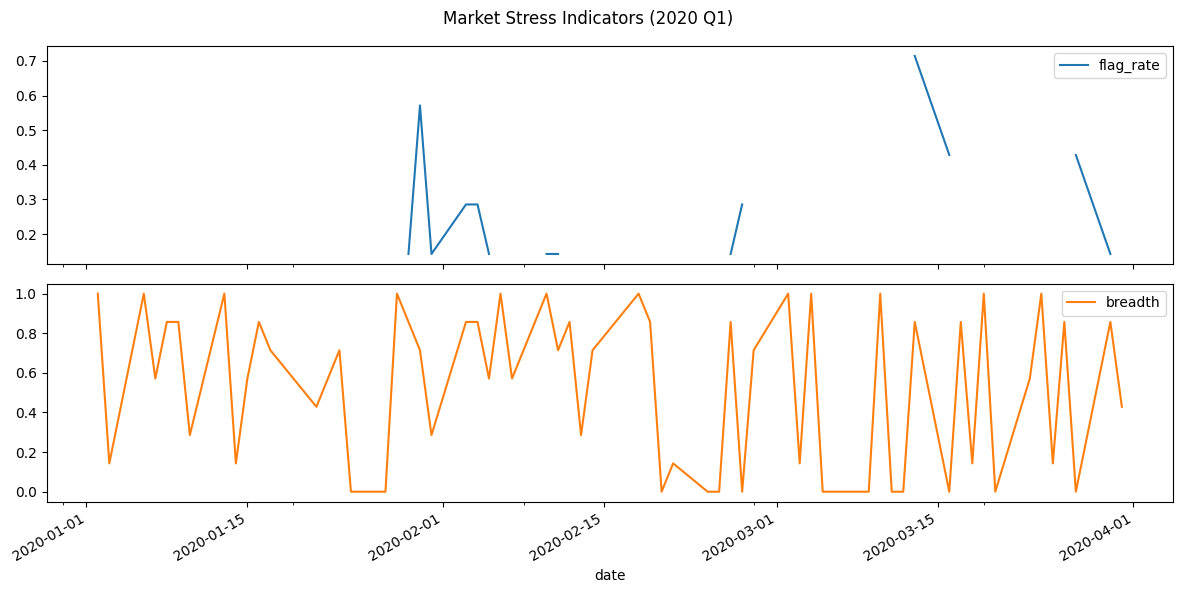

In [25]:
import matplotlib.pyplot as plt

df_market[["flag_rate", "breadth"]].plot(
    subplots=True,
    figsize=(12, 6),
    title="Market Stress Indicators (2020 Q1)"
)
plt.tight_layout()
plt.show()